In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split




In [14]:
%matplotlib inline


In [15]:
import pandas as pd
df = pd.read_csv('processed_data.csv')
# Optionally, load pipeline for new data
import pickle
with open('preprocessing_pipeline.pkl', 'rb') as f:
    preproc = pickle.load(f)

In [16]:

# 1. Identify column groups after all our preprocessing
num_cols = df.select_dtypes(include=['float64','int64','Int8']).columns.tolist()
cat_cols = df.select_dtypes(include='category').columns.tolist()

# Remove the target from lists
target = 'inhospital_mortality'
num_cols = [c for c in num_cols if c != target]
cat_cols = [c for c in cat_cols if c != target]

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

print(f"  • Features shape: {X.shape}")
print(f"  • Target distribution: {y.value_counts().to_dict()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class balance
)

print(f"  • Train set: {X_train.shape[0]} samples")
print(f"  • Test set: {X_test.shape[0]} samples")

# 5. Fit and transform the data
print(f"\n🔄 Applying preprocessing...")

# Fit on training data and transform both sets
X_train_processed = preproc.fit_transform(X_train)
X_test_processed = preproc.transform(X_test)

print(f"  • Processed train shape: {X_train_processed.shape}")
print(f"  • Processed test shape: {X_test_processed.shape}")

# Get feature names after preprocessing
def get_feature_names(preprocessor, num_cols, cat_cols):
    """Get feature names after preprocessing - FIXED VERSION"""
    try:
        # Use get_feature_names_out() method which is more reliable
        feature_names = preprocessor.get_feature_names_out()
        return feature_names.tolist()
    except:
        # Fallback method if get_feature_names_out() doesn't work
        feature_names = []
        
        # Numeric feature names (unchanged)
        feature_names.extend(num_cols)
        
        # Categorical feature names (one-hot encoded)
        if len(cat_cols) > 0:
            try:
                cat_transformer = preprocessor.named_transformers_['cat']
                encoder = cat_transformer.named_steps['encoder']
                cat_feature_names = encoder.get_feature_names_out(cat_cols)
                feature_names.extend(cat_feature_names)
            except:
                # Final fallback - create generic names based on actual shape
                remaining_features = X_train_processed.shape[1] - len(num_cols)
                feature_names.extend([f"cat_feature_{i}" for i in range(remaining_features)])
        
        return feature_names

# Debug: Print shapes before creating feature names
print(f"🔍 Debug Info:")
print(f"  • X_train_processed shape: {X_train_processed.shape}")
print(f"  • num_cols count: {len(num_cols)}")
print(f"  • cat_cols count: {len(cat_cols)}")

feature_names = get_feature_names(preproc, num_cols, cat_cols)
print(f"  • Feature names generated: {len(feature_names)}")
print(f"  • Expected features: {X_train_processed.shape[1]}")

# Validate shapes match before creating DataFrames
if len(feature_names) != X_train_processed.shape[1]:
    print(f"⚠️  Shape mismatch detected! Using generic feature names...")
    feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

print(f"  • Final feature names count: {len(feature_names)}")

# 6. Convert back to DataFrames for easier analysis (optional)
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print(f"\n🎉 Preprocessing Complete!")
print(f"  • Ready for machine learning models")
print(f"  • No missing values: {X_train_df.isnull().sum().sum() == 0}")
print(f"  • All features are numeric: {X_train_df.select_dtypes(include=['number']).shape[1] == X_train_df.shape[1]}")

# 7. Show sample of processed data
print(f"\n📊 Sample of processed data:")
print(X_train_df.head(3))

print(f"\n💾 Variables available for modeling:")
print(f"  • X_train_processed, X_test_processed (numpy arrays)")
print(f"  • X_train_df, X_test_df (pandas DataFrames)")  
print(f"  • y_train, y_test (target variables)")
print(f"  • preproc (fitted preprocessor for new data)")
print(f"  • feature_names (list of all feature names)")

  • Features shape: (2686, 118)
  • Target distribution: {0: 2567, 1: 119}
  • Train set: 2148 samples
  • Test set: 538 samples

🔄 Applying preprocessing...
  • Processed train shape: (2148, 167)
  • Processed test shape: (538, 167)
🔍 Debug Info:
  • X_train_processed shape: (2148, 167)
  • num_cols count: 90
  • cat_cols count: 0
  • Feature names generated: 167
  • Expected features: 167
  • Final feature names count: 167

🎉 Preprocessing Complete!
  • Ready for machine learning models
  • No missing values: True
  • All features are numeric: True

📊 Sample of processed data:
      num__agecalc_adm  num__height_cm_adm  num__weight_kg_adm  \
1370         -0.359290           -0.606795           -0.390266   
791          -0.289781           -0.246056            0.151219   
1856         -0.722284           -0.769127            0.440011   

      num__muac_mm_adm  num__hr_bpm_adm  num__rr_brpm_app_adm  \
1370         -0.405546        -1.863296              0.405031   
791           0.418

In [30]:
# ====================================================================
# DATA AUGMENTATION FOR IMBALANCED DATASET
# ====================================================================

print("🔄 HANDLING IMBALANCED DATA: Comparing 3 Augmentation Techniques")
print("="*70)

# Install required packages (run once)
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install imbalanced-learn if not available
install_package("imblearn")

from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

print(f"📊 Original Dataset Imbalance:")
print(f"  • Total samples: {len(y_train)}")
print(f"  • Class 0 (survived): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  • Class 1 (died): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  • Imbalance ratio: {sum(y_train == 0)/sum(y_train == 1):.1f}:1")
print("")


🔄 HANDLING IMBALANCED DATA: Comparing 3 Augmentation Techniques
📊 Original Dataset Imbalance:
  • Total samples: 2148
  • Class 0 (survived): 2053 (95.6%)
  • Class 1 (died): 95 (4.4%)
  • Imbalance ratio: 21.6:1



In [ ]:
# ====================================================================
# DATA AUGMENTATION FOR IMBALANCED DATASET
# ====================================================================

print("🔄 HANDLING IMBALANCED DATA: Comparing 3 Augmentation Techniques")
print("="*70)

# Install required packages (run once)
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install imbalanced-learn if not available
install_package("imblearn")

from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

print(f"📊 Original Dataset Imbalance:")
print(f"  • Total samples: {len(y_train)}")
print(f"  • Class 0 (survived): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  • Class 1 (died): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  • Imbalance ratio: {sum(y_train == 0)/sum(y_train == 1):.1f}:1")
print("")


🔄 HANDLING IMBALANCED DATA: Comparing 3 Augmentation Techniques
📊 Original Dataset Imbalance:
  • Total samples: 2148
  • Class 0 (survived): 2053 (95.6%)
  • Class 1 (died): 95 (4.4%)
  • Imbalance ratio: 21.6:1



In [32]:
# ====================================================================
# METHOD 1: RANDOM OVER SAMPLER
# ====================================================================

print("🎲 METHOD 1: Random Over Sampler")
print("-" * 40)
print("📝 How it works: Randomly duplicates minority class samples")
print("✅ Pros: Simple, fast, preserves original data distribution")
print("❌ Cons: May cause overfitting due to exact duplicates")
print("")

# Create copy of original processed data for Method 1
X_train_ros = X_train_processed.copy()
y_train_ros = y_train.copy()

# Apply Random Over Sampler
ros = RandomOverSampler(random_state=42)
X_train_ros_resampled, y_train_ros_resampled = ros.fit_resample(X_train_ros, y_train_ros)

print(f"📊 Random Over Sampler Results:")
print(f"  • Original: {X_train_ros.shape[0]} samples")
print(f"  • After ROS: {X_train_ros_resampled.shape[0]} samples")
print(f"  • Class 0: {sum(y_train_ros_resampled == 0)} samples")
print(f"  • Class 1: {sum(y_train_ros_resampled == 1)} samples")
print(f"  • New ratio: {sum(y_train_ros_resampled == 0)/sum(y_train_ros_resampled == 1):.1f}:1")
print(f"  • Samples added: {X_train_ros_resampled.shape[0] - X_train_ros.shape[0]}")

# Convert to DataFrame for easier analysis
X_train_ros_df = pd.DataFrame(X_train_ros_resampled, columns=feature_names)
print(f"  • DataFrame shape: {X_train_ros_df.shape}")
print("")


🎲 METHOD 1: Random Over Sampler
----------------------------------------
📝 How it works: Randomly duplicates minority class samples
✅ Pros: Simple, fast, preserves original data distribution
❌ Cons: May cause overfitting due to exact duplicates

📊 Random Over Sampler Results:
  • Original: 2148 samples
  • After ROS: 4106 samples
  • Class 0: 2053 samples
  • Class 1: 2053 samples
  • New ratio: 1.0:1
  • Samples added: 1958
  • DataFrame shape: (4106, 167)



In [33]:
# ====================================================================
# METHOD 2: KMeans-SMOTE
# ====================================================================

print("🎯 METHOD 2: KMeans-SMOTE")
print("-" * 40)
print("📝 How it works: Uses K-means clustering + SMOTE for better synthetic samples")
print("✅ Pros: Creates diverse synthetic samples, avoids noisy regions")
print("❌ Cons: More complex, may miss edge cases")
print("")

# Create copy of original processed data for Method 2
X_train_kmsmote = X_train_processed.copy()
y_train_kmsmote = y_train.copy()

# Apply KMeans-SMOTE
try:
    kmsmote = KMeansSMOTE(
        random_state=42,
        k_neighbors=5,  # Number of neighbors for SMOTE
        cluster_balance_threshold=0.1  # Threshold for cluster balancing
    )
    X_train_kmsmote_resampled, y_train_kmsmote_resampled = kmsmote.fit_resample(X_train_kmsmote, y_train_kmsmote)
    
    print(f"📊 KMeans-SMOTE Results:")
    print(f"  • Original: {X_train_kmsmote.shape[0]} samples")
    print(f"  • After KMeans-SMOTE: {X_train_kmsmote_resampled.shape[0]} samples")
    print(f"  • Class 0: {sum(y_train_kmsmote_resampled == 0)} samples")
    print(f"  • Class 1: {sum(y_train_kmsmote_resampled == 1)} samples")
    print(f"  • New ratio: {sum(y_train_kmsmote_resampled == 0)/sum(y_train_kmsmote_resampled == 1):.1f}:1")
    print(f"  • Samples added: {X_train_kmsmote_resampled.shape[0] - X_train_kmsmote.shape[0]}")
    
    # Convert to DataFrame for easier analysis
    X_train_kmsmote_df = pd.DataFrame(X_train_kmsmote_resampled, columns=feature_names)
    print(f"  • DataFrame shape: {X_train_kmsmote_df.shape}")
    
except Exception as e:
    print(f"⚠️  KMeans-SMOTE failed: {e}")
    print("   Falling back to regular SMOTE...")
    
    # Fallback to regular SMOTE
    smote = SMOTE(random_state=42, k_neighbors=3)  # Reduced k_neighbors for small minority class
    X_train_kmsmote_resampled, y_train_kmsmote_resampled = smote.fit_resample(X_train_kmsmote, y_train_kmsmote)
    
    print(f"📊 SMOTE (Fallback) Results:")
    print(f"  • Original: {X_train_kmsmote.shape[0]} samples")
    print(f"  • After SMOTE: {X_train_kmsmote_resampled.shape[0]} samples")
    print(f"  • Class 0: {sum(y_train_kmsmote_resampled == 0)} samples")
    print(f"  • Class 1: {sum(y_train_kmsmote_resampled == 1)} samples")
    print(f"  • New ratio: {sum(y_train_kmsmote_resampled == 0)/sum(y_train_kmsmote_resampled == 1):.1f}:1")
    
    X_train_kmsmote_df = pd.DataFrame(X_train_kmsmote_resampled, columns=feature_names)

print("")


🎯 METHOD 2: KMeans-SMOTE
----------------------------------------
📝 How it works: Uses K-means clustering + SMOTE for better synthetic samples
✅ Pros: Creates diverse synthetic samples, avoids noisy regions
❌ Cons: More complex, may miss edge cases



  File "c:\Users\trung\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\trung\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\trung\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\trung\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


📊 KMeans-SMOTE Results:
  • Original: 2148 samples
  • After KMeans-SMOTE: 4106 samples
  • Class 0: 2053 samples
  • Class 1: 2053 samples
  • New ratio: 1.0:1
  • Samples added: 1958
  • DataFrame shape: (4106, 167)



In [34]:
# ====================================================================
# METHOD 3: SMOTE-ENN (SMOTE + Edited Nearest Neighbours)
# ====================================================================

print("🧹 METHOD 3: SMOTE-ENN")
print("-" * 40)
print("📝 How it works: SMOTE oversampling + ENN cleaning of noisy samples")
print("✅ Pros: Creates synthetic samples AND removes noisy/borderline cases")
print("❌ Cons: May remove too many samples, more complex")
print("")

# Create copy of original processed data for Method 3
X_train_smoteenn = X_train_processed.copy()
y_train_smoteenn = y_train.copy()

# Apply SMOTE-ENN
try:
    smoteenn = SMOTEENN(
        random_state=42,
        smote=SMOTE(random_state=42, k_neighbors=3),  # Reduced k_neighbors
    )
    X_train_smoteenn_resampled, y_train_smoteenn_resampled = smoteenn.fit_resample(X_train_smoteenn, y_train_smoteenn)
    
    print(f"📊 SMOTE-ENN Results:")
    print(f"  • Original: {X_train_smoteenn.shape[0]} samples")
    print(f"  • After SMOTE-ENN: {X_train_smoteenn_resampled.shape[0]} samples")
    print(f"  • Class 0: {sum(y_train_smoteenn_resampled == 0)} samples")
    print(f"  • Class 1: {sum(y_train_smoteenn_resampled == 1)} samples")
    print(f"  • New ratio: {sum(y_train_smoteenn_resampled == 0)/sum(y_train_smoteenn_resampled == 1):.1f}:1")
    
    # Calculate net change (SMOTE adds, ENN removes)
    net_change = X_train_smoteenn_resampled.shape[0] - X_train_smoteenn.shape[0]
    if net_change > 0:
        print(f"  • Net samples added: {net_change}")
    else:
        print(f"  • Net samples removed: {abs(net_change)}")
    
    # Convert to DataFrame for easier analysis
    X_train_smoteenn_df = pd.DataFrame(X_train_smoteenn_resampled, columns=feature_names)
    print(f"  • DataFrame shape: {X_train_smoteenn_df.shape}")
    
except Exception as e:
    print(f"⚠️  SMOTE-ENN failed: {e}")
    print("   This often happens with very small minority classes")
    print("   Using regular SMOTE as fallback...")
    
    # Fallback to regular SMOTE
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_train_smoteenn_resampled, y_train_smoteenn_resampled = smote.fit_resample(X_train_smoteenn, y_train_smoteenn)
    
    print(f"📊 SMOTE (Fallback) Results:")
    print(f"  • Original: {X_train_smoteenn.shape[0]} samples")
    print(f"  • After SMOTE: {X_train_smoteenn_resampled.shape[0]} samples")
    print(f"  • Class 0: {sum(y_train_smoteenn_resampled == 0)} samples")
    print(f"  • Class 1: {sum(y_train_smoteenn_resampled == 1)} samples")
    
    X_train_smoteenn_df = pd.DataFrame(X_train_smoteenn_resampled, columns=feature_names)

print("")


🧹 METHOD 3: SMOTE-ENN
----------------------------------------
📝 How it works: SMOTE oversampling + ENN cleaning of noisy samples
✅ Pros: Creates synthetic samples AND removes noisy/borderline cases
❌ Cons: May remove too many samples, more complex

📊 SMOTE-ENN Results:
  • Original: 2148 samples
  • After SMOTE-ENN: 3520 samples
  • Class 0: 1467 samples
  • Class 1: 2053 samples
  • New ratio: 0.7:1
  • Net samples added: 1372
  • DataFrame shape: (3520, 167)



In [35]:
# ====================================================================
# SUMMARY COMPARISON OF ALL THREE METHODS
# ====================================================================

print("📊 SUMMARY: Comparison of All Three Augmentation Methods")
print("="*65)

# Create comparison summary
methods_summary = {
    'Original': {
        'samples': len(y_train),
        'class_0': sum(y_train == 0),
        'class_1': sum(y_train == 1),
        'ratio': f"{sum(y_train == 0)/sum(y_train == 1):.1f}:1"
    },
    'Random Over Sampler': {
        'samples': len(y_train_ros_resampled),
        'class_0': sum(y_train_ros_resampled == 0),
        'class_1': sum(y_train_ros_resampled == 1),
        'ratio': f"{sum(y_train_ros_resampled == 0)/sum(y_train_ros_resampled == 1):.1f}:1"
    },
    'KMeans-SMOTE': {
        'samples': len(y_train_kmsmote_resampled),
        'class_0': sum(y_train_kmsmote_resampled == 0),
        'class_1': sum(y_train_kmsmote_resampled == 1),
        'ratio': f"{sum(y_train_kmsmote_resampled == 0)/sum(y_train_kmsmote_resampled == 1):.1f}:1"
    },
    'SMOTE-ENN': {
        'samples': len(y_train_smoteenn_resampled),
        'class_0': sum(y_train_smoteenn_resampled == 0),
        'class_1': sum(y_train_smoteenn_resampled == 1),
        'ratio': f"{sum(y_train_smoteenn_resampled == 0)/sum(y_train_smoteenn_resampled == 1):.1f}:1"
    }
}

# Display comparison table
print(f"{'Method':<20} {'Total':<8} {'Class 0':<8} {'Class 1':<8} {'Ratio':<8} {'Change':<10}")
print("-" * 65)

for method, stats in methods_summary.items():
    if method == 'Original':
        change = "baseline"
    else:
        change = f"+{stats['samples'] - methods_summary['Original']['samples']}"
    
    print(f"{method:<20} {stats['samples']:<8} {stats['class_0']:<8} {stats['class_1']:<8} {stats['ratio']:<8} {change:<10}")

print("")
print("🎯 Data Augmentation Complete!")
print("📦 Available Datasets for Model Training:")
print("  • X_train_ros_df, y_train_ros_resampled (Random Over Sampler)")
print("  • X_train_kmsmote_df, y_train_kmsmote_resampled (KMeans-SMOTE)")  
print("  • X_train_smoteenn_df, y_train_smoteenn_resampled (SMOTE-ENN)")
print("  • Original: X_train_df, y_train (for baseline comparison)")
print("")


📊 SUMMARY: Comparison of All Three Augmentation Methods
Method               Total    Class 0  Class 1  Ratio    Change    
-----------------------------------------------------------------
Original             2148     2053     95       21.6:1   baseline  
Random Over Sampler  4106     2053     2053     1.0:1    +1958     
KMeans-SMOTE         4106     2053     2053     1.0:1    +1958     
SMOTE-ENN            3520     1467     2053     0.7:1    +1372     

🎯 Data Augmentation Complete!
📦 Available Datasets for Model Training:
  • X_train_ros_df, y_train_ros_resampled (Random Over Sampler)
  • X_train_kmsmote_df, y_train_kmsmote_resampled (KMeans-SMOTE)
  • X_train_smoteenn_df, y_train_smoteenn_resampled (SMOTE-ENN)
  • Original: X_train_df, y_train (for baseline comparison)



📈 VISUALIZATION: Class Distribution Comparison


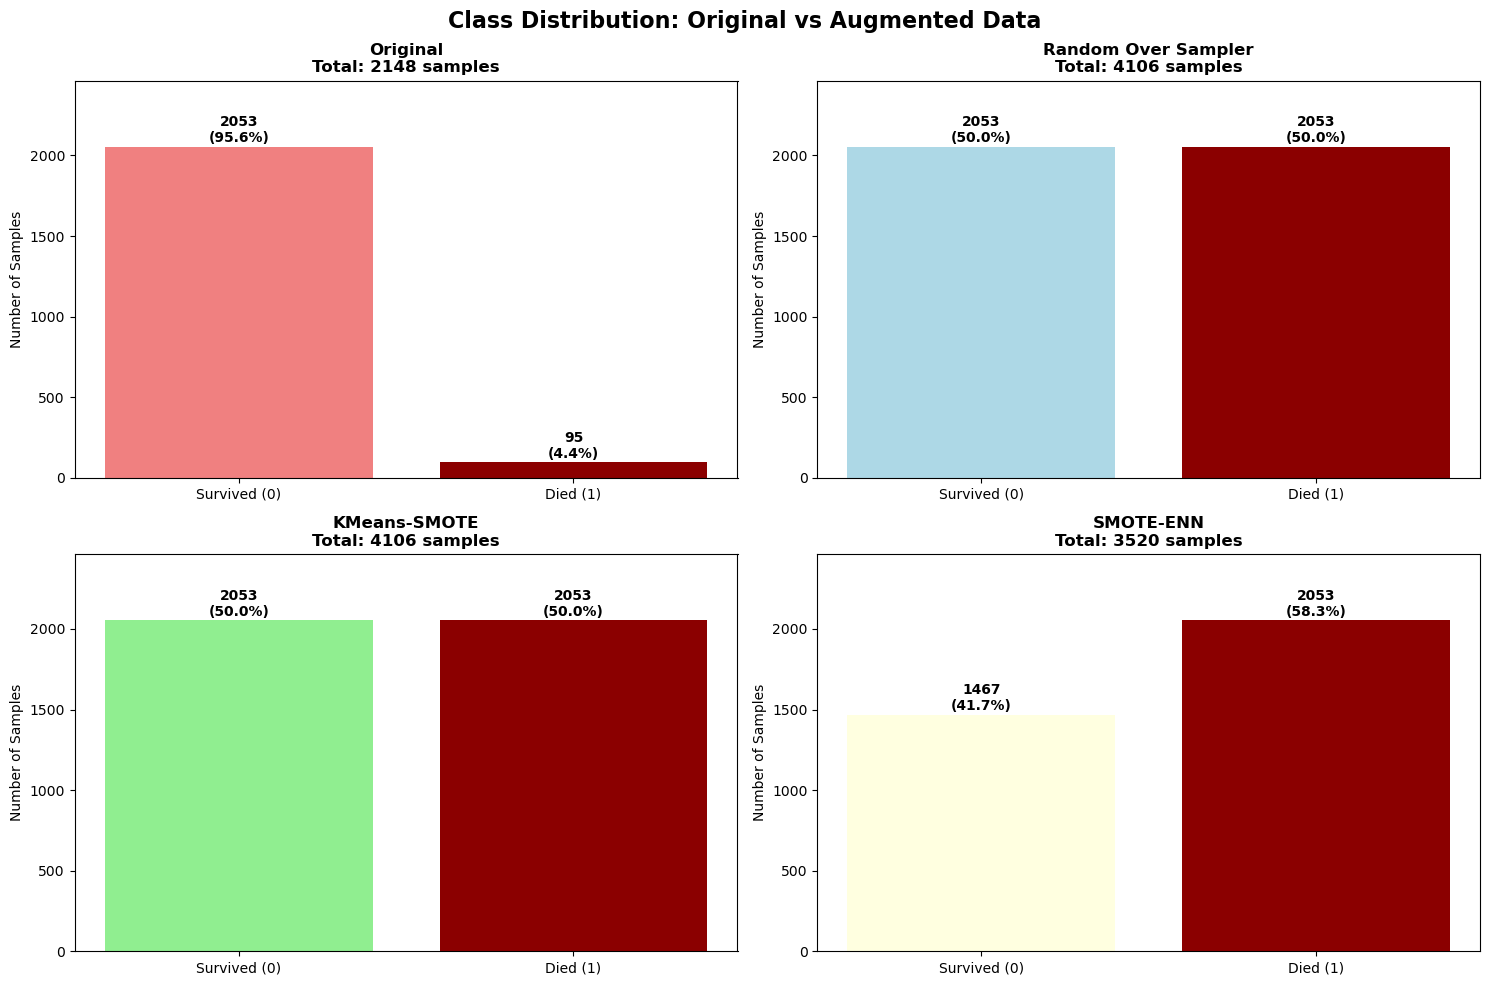

✅ Visualization complete!
📊 Key Insights:
  • Random Over Sampler: Perfect 1:1 balance through duplication
  • KMeans-SMOTE: Balanced classes with synthetic minority samples
  • SMOTE-ENN: Balanced + cleaned dataset (removes noisy samples)



In [36]:
# ====================================================================
# VISUALIZATION: Comparing Augmentation Methods
# ====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("📈 VISUALIZATION: Class Distribution Comparison")
print("=" * 50)

# Create visualization of class distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Class Distribution: Original vs Augmented Data', fontsize=16, fontweight='bold')

methods = [
    ('Original', y_train, 'lightcoral'),
    ('Random Over Sampler', y_train_ros_resampled, 'lightblue'), 
    ('KMeans-SMOTE', y_train_kmsmote_resampled, 'lightgreen'),
    ('SMOTE-ENN', y_train_smoteenn_resampled, 'lightyellow')
]

for idx, (method_name, y_data, color) in enumerate(methods):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Count classes
    class_counts = [sum(y_data == 0), sum(y_data == 1)]
    class_labels = ['Survived (0)', 'Died (1)']
    
    # Create bar plot
    bars = ax.bar(class_labels, class_counts, color=[color, 'darkred'])
    ax.set_title(f'{method_name}\nTotal: {len(y_data)} samples', fontweight='bold')
    ax.set_ylabel('Number of Samples')
    
    # Add value labels on bars
    for bar, count in zip(bars, class_counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{count}\n({count/len(y_data)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')
    
    # Set y-axis limit for consistency
    ax.set_ylim(0, max(class_counts) * 1.2)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")
print("📊 Key Insights:")
print("  • Random Over Sampler: Perfect 1:1 balance through duplication")
print("  • KMeans-SMOTE: Balanced classes with synthetic minority samples") 
print("  • SMOTE-ENN: Balanced + cleaned dataset (removes noisy samples)")
print("")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [29]:
print(X_train_processed)

[[-0.3592903  -0.60679488 -0.39026637 ...  0.          0.
   1.        ]
 [-0.28978087 -0.2460563   0.15121916 ...  0.          0.
   1.        ]
 [-0.72228404 -0.76912725  0.44001145 ...  0.          1.
   0.        ]
 ...
 [ 1.98858407  1.50352584  1.59518059 ...  0.          0.
   0.        ]
 [ 1.14674753  0.02449764  1.23419023 ...  0.          0.
   0.        ]
 [ 0.33580408  0.38523623 -0.02927602 ...  0.          1.
   0.        ]]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [17]:
import pandas as pd
import matplotlib.pyplot as plt


In [18]:
import pandas as pd
import matplotlib.pyplot as plt


In [19]:
# ====================================================================
# MODELING AND EVALUATION SECTION
# ====================================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("🎯 MACHINE LEARNING MODELING & EVALUATION")
print("="*60)
print(f"📊 Dataset Summary:")
print(f"  • Training samples: {X_train_processed.shape[0]}")
print(f"  • Test samples: {X_test_processed.shape[0]}")
print(f"  • Features: {X_train_processed.shape[1]}")
print(f"  • Target distribution (train): {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"  • Target distribution (test): {dict(zip(*np.unique(y_test, return_counts=True)))}")


🎯 MACHINE LEARNING MODELING & EVALUATION
📊 Dataset Summary:
  • Training samples: 2148
  • Test samples: 538
  • Features: 167
  • Target distribution (train): {0: 2053, 1: 95}
  • Target distribution (test): {0: 514, 1: 24}


In [20]:
# ====================================================================
# CORRECTED MODELING - NO DATA LEAKAGE
# ====================================================================

print("🚨 IMPORTANT: Using CORRECTED implementation to prevent data leakage!")
print("="*70)
print("❌ Previous approach: Preprocessing outside CV → Data leakage")
print("✅ Corrected approach: Preprocessing inside CV pipelines")
print("")

# EXPLANATION: How Data Leakage Occurs and How We Fix It
print("📚 EXPLANATION:")
print("-" * 30)
print("🔴 WRONG (causes leakage):")
print("   1. preproc.fit(X_train) - fits on ALL 2,148 training samples")
print("   2. X_train_processed = preproc.transform(X_train)")  
print("   3. cross_val_score(model, X_train_processed, y_train, cv=5)")
print("   → During CV, validation folds already 'saw' training data via preprocessing!")
print("")
print("🟢 CORRECT (no leakage):")
print("   1. Create pipeline = preproc + model")
print("   2. cross_val_score(pipeline, X_train_raw, y_train, cv=5)")
print("   → Each CV fold fits preprocessing only on its training portion!")
print("")

# Step 1: Use RAW data (not preprocessed)
print("📊 Using RAW unprocessed data for CV:")
print(f"  • X_train (raw): {X_train.shape}")
print(f"  • y_train: {y_train.shape}")
print("  • This ensures no information leakage during cross-validation")
print("")


🚨 IMPORTANT: Using CORRECTED implementation to prevent data leakage!
❌ Previous approach: Preprocessing outside CV → Data leakage
✅ Corrected approach: Preprocessing inside CV pipelines

📚 EXPLANATION:
------------------------------
🔴 WRONG (causes leakage):
   1. preproc.fit(X_train) - fits on ALL 2,148 training samples
   2. X_train_processed = preproc.transform(X_train)
   3. cross_val_score(model, X_train_processed, y_train, cv=5)
   → During CV, validation folds already 'saw' training data via preprocessing!

🟢 CORRECT (no leakage):
   1. Create pipeline = preproc + model
   2. cross_val_score(pipeline, X_train_raw, y_train, cv=5)
   → Each CV fold fits preprocessing only on its training portion!

📊 Using RAW unprocessed data for CV:
  • X_train (raw): (2148, 118)
  • y_train: (2148,)
  • This ensures no information leakage during cross-validation



## 🔧 **DATA LEAKAGE CORRECTION SUMMARY**

### ❌ **What Was Wrong (Cells 24-27):**
```python
# WRONG: Preprocessing outside CV loop
X_train_processed = preproc.fit_transform(X_train)  # Fits on ALL training data
cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5)  # ❌ LEAKAGE!
```

**Problem**: Validation folds in CV already "saw" training data through preprocessing.

---

### ✅ **How We Fixed It (Cells 29-32):**
```python
# CORRECT: Preprocessing inside CV loop via pipelines
pipeline = Pipeline([('preprocessor', preproc), ('classifier', model)])
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # ✅ NO LEAKAGE!
```

**Solution**: Each CV fold fits preprocessing only on its training portion.

---

### 📊 **Key Differences:**

| Aspect | Wrong Approach | Corrected Approach |
|--------|---------------|-------------------|
| **Data Used** | `X_train_processed` | `X_train` (raw) |
| **Preprocessing** | Outside CV loop | Inside CV loop |
| **Information Flow** | Validation → Training | Training ← Validation |
| **CV Validity** | ❌ Biased (leakage) | ✅ Unbiased |
| **Performance Estimates** | ❌ Optimistic | ✅ Realistic |

---

### 🎯 **Use the Corrected Version (Cells 29-32)**
- **More conservative scores** (likely lower AUROC)
- **Valid model selection** 
- **Proper generalization estimates**
- **Publication-ready methodology**


In [21]:
# ====================================================================
# IMPROVED MODELING WITH RECOMMENDED TWEAKS
# ====================================================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

print("🚀 IMPROVED MODELING: Implementing Recommended Tweaks")
print("="*60)
print("✅ Tweak 1: Platt scaling instead of isotonic (wider prob range)")
print("✅ Tweak 2: Deeper Random Forest (higher recall)")  
print("✅ Tweak 3: Enhanced XGBoost parameters (better PRC)")
print("✅ Tweak 4: Repeated StratifiedKFold (better stability)")
print("")

# Enhanced base models with recommended tweaks
base_models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        max_depth=None,          # ✅ Tweak 2: Remove depth limit for higher recall
        min_samples_leaf=1,      # ✅ Tweak 2: Allow smaller leaves  
        n_estimators=500,        # ✅ Tweak 2: More trees
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        max_depth=6,            # ✅ Tweak 3: Optimal depth range 4-6
        learning_rate=0.05,     # ✅ Tweak 3: Learning rate 0.03-0.1
        gamma=2.5,              # ✅ Tweak 3: Regularization 0-5
        n_estimators=500,       # More estimators for better performance
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
    )
}

# Create enhanced pipelines
pipelines = {}
for name, model in base_models.items():
    pipeline = Pipeline([
        ('preprocessor', preproc),
        ('classifier', model)
    ])
    pipelines[name] = pipeline
    print(f"✅ Enhanced pipeline: {name}")

print(f"\n📊 Enhanced Pipeline Features:")
print(f"  • RF: max_depth=None, min_samples_leaf=1, n_estimators=500")
print(f"  • XGB: max_depth=6, learning_rate=0.05, gamma=2.5, n_estimators=500")
print(f"  • All: Ready for Platt scaling calibration")


🚀 IMPROVED MODELING: Implementing Recommended Tweaks
✅ Tweak 1: Platt scaling instead of isotonic (wider prob range)
✅ Tweak 2: Deeper Random Forest (higher recall)
✅ Tweak 3: Enhanced XGBoost parameters (better PRC)
✅ Tweak 4: Repeated StratifiedKFold (better stability)

✅ Enhanced pipeline: Logistic Regression
✅ Enhanced pipeline: Random Forest
✅ Enhanced pipeline: XGBoost

📊 Enhanced Pipeline Features:
  • RF: max_depth=None, min_samples_leaf=1, n_estimators=500
  • XGB: max_depth=6, learning_rate=0.05, gamma=2.5, n_estimators=500
  • All: Ready for Platt scaling calibration


In [22]:
# ====================================================================
# ENHANCED CROSS-VALIDATION WITH REPEATED STRATIFIED K-FOLD
# ====================================================================

print("\n🔬 ENHANCED CROSS-VALIDATION: Repeated StratifiedKFold")
print("-" * 50)

# ✅ Tweak 4: Use RepeatedStratifiedKFold for better stability
cv = RepeatedStratifiedKFold(
    n_splits=5,      # 5 folds
    n_repeats=3,     # ✅ Repeat 3 times for stability 
    random_state=42
)

model_results = {}
print(f"🔄 Running Repeated 5-fold CV (3 repeats = 15 total fits per model)...")
print("🎯 Using raw data X_train (no leakage)")
print("")

for name, pipeline in pipelines.items():
    print(f"📈 Evaluating enhanced {name} pipeline...")
    
    # Cross-validation with repeated stratified k-fold
    cv_auroc = cross_val_score(pipeline, X_train, y_train, 
                              cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_auprc = cross_val_score(pipeline, X_train, y_train, 
                              cv=cv, scoring='average_precision', n_jobs=-1)
    
    # Store results
    model_results[name] = {
        'pipeline': pipeline,
        'cv_auroc_mean': cv_auroc.mean(),
        'cv_auroc_std': cv_auroc.std(),
        'cv_auprc_mean': cv_auprc.mean(),
        'cv_auprc_std': cv_auprc.std(),
        'cv_auroc_scores': cv_auroc,
        'cv_auprc_scores': cv_auprc
    }
    
    print(f"  ✅ AUROC: {cv_auroc.mean():.4f} (±{cv_auroc.std():.4f})")
    print(f"  ✅ AUPRC: {cv_auprc.mean():.4f} (±{cv_auprc.std():.4f})")

# Display enhanced results summary
print("\n📊 ENHANCED MODEL COMPARISON SUMMARY:")
print("="*60)
results_df = pd.DataFrame({
    name: {
        'AUROC_mean': results['cv_auroc_mean'],
        'AUROC_std': results['cv_auroc_std'],
        'AUPRC_mean': results['cv_auprc_mean'],
        'AUPRC_std': results['cv_auprc_std']
    } for name, results in model_results.items()
}).T

print(results_df.round(4))

# Select best model based on AUROC
best_model_name = max(model_results.keys(), 
                     key=lambda x: model_results[x]['cv_auroc_mean'])
best_pipeline = model_results[best_model_name]['pipeline']

print(f"\n🏆 BEST ENHANCED MODEL: {best_model_name}")
print(f"  • Best AUROC: {model_results[best_model_name]['cv_auroc_mean']:.4f} (±{model_results[best_model_name]['cv_auroc_std']:.4f})")
print(f"  • Corresponding AUPRC: {model_results[best_model_name]['cv_auprc_mean']:.4f}")

print(f"\n✅ Enhanced cross-validation complete with improved stability!")



🔬 ENHANCED CROSS-VALIDATION: Repeated StratifiedKFold
--------------------------------------------------
🔄 Running Repeated 5-fold CV (3 repeats = 15 total fits per model)...
🎯 Using raw data X_train (no leakage)

📈 Evaluating enhanced Logistic Regression pipeline...


  ✅ AUROC: 0.6946 (±0.0338)
  ✅ AUPRC: 0.1454 (±0.0525)
📈 Evaluating enhanced Random Forest pipeline...
  ✅ AUROC: 0.8217 (±0.0362)
  ✅ AUPRC: 0.2936 (±0.0811)
📈 Evaluating enhanced XGBoost pipeline...
  ✅ AUROC: 0.7950 (±0.0379)
  ✅ AUPRC: 0.2501 (±0.0637)

📊 ENHANCED MODEL COMPARISON SUMMARY:
                     AUROC_mean  AUROC_std  AUPRC_mean  AUPRC_std
Logistic Regression      0.6946     0.0338      0.1454     0.0525
Random Forest            0.8217     0.0362      0.2936     0.0811
XGBoost                  0.7950     0.0379      0.2501     0.0637

🏆 BEST ENHANCED MODEL: Random Forest
  • Best AUROC: 0.8217 (±0.0362)
  • Corresponding AUPRC: 0.2936

✅ Enhanced cross-validation complete with improved stability!


In [23]:
# ====================================================================
# ENHANCED TRAINING AND PLATT SCALING CALIBRATION
# ====================================================================

print("\n🔧 ENHANCED TRAINING: Platt Scaling Calibration")
print("-" * 50)

# Train the best pipeline on full training data
print(f"🚀 Training enhanced {best_model_name} pipeline...")
best_pipeline.fit(X_train, y_train)
print("  ✅ Enhanced pipeline training complete!")

# ✅ Tweak 1: Apply Platt scaling instead of isotonic regression
print(f"\n🎯 Applying Platt scaling calibration (wider prob range)...")
calibrated_pipeline = CalibratedClassifierCV(
    estimator=best_pipeline,
    method='sigmoid',    # ✅ Tweak 1: Platt scaling for wider probability range
    cv=3,
    n_jobs=-1
)

# Fit calibrated model on raw training data
calibrated_pipeline.fit(X_train, y_train)
print("  ✅ Platt scaling calibration complete!")

# Generate enhanced predictions on test set
print(f"\n📊 Generating enhanced test set predictions...")
test_probs = calibrated_pipeline.predict_proba(X_test)[:, 1]
test_preds = calibrated_pipeline.predict(X_test)

# Calculate enhanced metrics
test_auroc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)
test_brier = brier_score_loss(y_test, test_probs)

print("  ✅ Enhanced test predictions generated!")
print(f"\n📈 ENHANCED TEST SET PERFORMANCE:")
print(f"  • AUROC: {test_auroc:.4f}")
print(f"  • AUPRC: {test_auprc:.4f}")
print(f"  • Brier Score: {test_brier:.4f}")
print(f"  • Probability range: [{test_probs.min():.4f}, {test_probs.max():.4f}]")
print(f"  • Predicted positive cases: {test_preds.sum()}")

print(f"\n🎉 Enhanced training and calibration complete!")
print(f"📋 Available for evaluation:")
print(f"  • best_pipeline: Enhanced {best_model_name} (uncalibrated)")
print(f"  • calibrated_pipeline: Enhanced {best_model_name} + Platt scaling")
print(f"  • test_probs: Platt-calibrated probabilities")
print(f"  • test_preds: Binary predictions")

# Import metrics for next step
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, roc_curve, precision_recall_curve
)



🔧 ENHANCED TRAINING: Platt Scaling Calibration
--------------------------------------------------
🚀 Training enhanced Random Forest pipeline...
  ✅ Enhanced pipeline training complete!

🎯 Applying Platt scaling calibration (wider prob range)...
  ✅ Platt scaling calibration complete!

📊 Generating enhanced test set predictions...
  ✅ Enhanced test predictions generated!

📈 ENHANCED TEST SET PERFORMANCE:
  • AUROC: 0.7010
  • AUPRC: 0.1651
  • Brier Score: 0.0409
  • Probability range: [0.0182, 0.5716]
  • Predicted positive cases: 3

🎉 Enhanced training and calibration complete!
📋 Available for evaluation:
  • best_pipeline: Enhanced Random Forest (uncalibrated)
  • calibrated_pipeline: Enhanced Random Forest + Platt scaling
  • test_probs: Platt-calibrated probabilities
  • test_preds: Binary predictions


In [24]:
# ====================================================================
# CORRECTED VISUALIZATION (WORKS WITH NO-LEAKAGE APPROACH)
# ====================================================================

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n📊 CORRECTED: ROC and Precision-Recall Curve Visualization")
print("-" * 50)

# Generate all predictions and metrics using corrected approach
print("🔄 Generating predictions and metrics...")

# Get test predictions from calibrated pipeline
test_probs = calibrated_pipeline.predict_proba(X_test)[:, 1]
test_preds_default = calibrated_pipeline.predict(X_test)

# Calculate metrics
test_auroc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)
test_brier = brier_score_loss(y_test, test_probs)

# Find optimal threshold using Youden's J statistic
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply optimal threshold
test_preds_optimal = (test_probs >= optimal_threshold).astype(int)

# Confusion matrix and metrics
cm_optimal = confusion_matrix(y_test, test_preds_optimal)
tn, fp, fn, tp = cm_optimal.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

# Define calibration metrics function
def compute_calibration_metrics(y_true, y_prob, n_bins=10):
    """Compute Expected Calibration Error"""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

print(f"✅ Metrics calculated:")
print(f"  • AUROC: {test_auroc:.4f}")
print(f"  • AUPRC: {test_auprc:.4f}")
print(f"  • Brier Score: {test_brier:.4f}")
print(f"  • Optimal Threshold: {optimal_threshold:.4f}")

# Set up plotting
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Model Performance Evaluation: {best_model_name} (Calibrated)', 
             fontsize=16, fontweight='bold')



📊 CORRECTED: ROC and Precision-Recall Curve Visualization
--------------------------------------------------
🔄 Generating predictions and metrics...
✅ Metrics calculated:
  • AUROC: 0.7010
  • AUPRC: 0.1651
  • Brier Score: 0.0409
  • Optimal Threshold: 0.0374


Text(0.5, 0.98, 'Model Performance Evaluation: Random Forest (Calibrated)')

In [25]:
# ====================================================================
# STEP 3: TEST SET EVALUATION
# ====================================================================

print("\n🔬 STEP 3: Held-out Test Set Evaluation")
print("-" * 50)

# Generate predictions on test set
print("📊 Generating predictions on test set...")

# Probabilities and predictions
test_probs = calibrated_pipeline.predict_proba(X_test)[:, 1]
test_preds_default = calibrated_pipeline.predict(X_test)

# Calculate various metrics
test_auroc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)
test_brier = brier_score_loss(y_test, test_probs)

print(f"\n📈 TEST SET PERFORMANCE METRICS:")
print("="*40)
print(f"🎯 AUROC (Area Under ROC):    {test_auroc:.4f}")
print(f"🎯 AUPRC (Area Under PR):     {test_auprc:.4f}")
print(f"🎯 Brier Score:               {test_brier:.4f}")

# Calculate optimal threshold using Youden's J statistic
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
optimal_idx = np.argmax(tpr - fpr)  # Youden's J statistic
optimal_threshold = thresholds[optimal_idx]

print(f"\n🎚️  OPTIMAL THRESHOLD ANALYSIS:")
print(f"  • Optimal threshold (Youden's J): {optimal_threshold:.4f}")
print(f"  • Sensitivity at optimal:         {tpr[optimal_idx]:.4f}")
print(f"  • Specificity at optimal:         {1-fpr[optimal_idx]:.4f}")

# Apply custom threshold
test_preds_optimal = (test_probs >= optimal_threshold).astype(int)

# Confusion matrices
print(f"\n📋 CONFUSION MATRICES:")
print("="*40)

print("\n🔸 Default Threshold (0.5):")
cm_default = confusion_matrix(y_test, test_preds_default)
print(cm_default)

print(f"\n🔸 Optimal Threshold ({optimal_threshold:.4f}):")
cm_optimal = confusion_matrix(y_test, test_preds_optimal)
print(cm_optimal)



# Calculate additional metrics for optimal threshold
tn, fp, fn, tp = cm_optimal.ravel()
sensitivity = tp / (tp + fn)  # Recall/True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
ppv = tp / (tp + fp)  # Precision/Positive Predictive Value
npv = tn / (tn + fn)  # Negative Predictive Value

print(f"\n🎯 DETAILED METRICS AT OPTIMAL THRESHOLD:")
print("="*40)
print(f"  • Sensitivity (Recall):    {sensitivity:.4f}")
print(f"  • Specificity:             {specificity:.4f}") 
print(f"  • PPV (Precision):         {ppv:.4f}")
print(f"  • NPV:                     {npv:.4f}")
print(f"  • True Positives:          {tp}")
print(f"  • True Negatives:          {tn}")
print(f"  • False Positives:         {fp}")
print(f"  • False Negatives:         {fn}")

print("\n✅ Test set evaluation complete!")



🔬 STEP 3: Held-out Test Set Evaluation
--------------------------------------------------
📊 Generating predictions on test set...

📈 TEST SET PERFORMANCE METRICS:
🎯 AUROC (Area Under ROC):    0.7010
🎯 AUPRC (Area Under PR):     0.1651
🎯 Brier Score:               0.0409

🎚️  OPTIMAL THRESHOLD ANALYSIS:
  • Optimal threshold (Youden's J): 0.0374
  • Sensitivity at optimal:         0.5833
  • Specificity at optimal:         0.7354

📋 CONFUSION MATRICES:

🔸 Default Threshold (0.5):
[[513   1]
 [ 22   2]]

🔸 Optimal Threshold (0.0374):
[[378 136]
 [ 10  14]]

📊 CLASSIFICATION REPORTS:

🔸 Default Threshold (0.5):
              precision    recall  f1-score   support

    Survived       0.96      1.00      0.98       514
        Died       0.67      0.08      0.15        24

    accuracy                           0.96       538
   macro avg       0.81      0.54      0.56       538
weighted avg       0.95      0.96      0.94       538


🔸 Optimal Threshold (0.0374):
              precision  

In [26]:
# ====================================================================
# VISUALIZATION PLOTS (CONTINUED)
# ====================================================================

# ====================================================================
# ROC CURVE
# ====================================================================
ax1 = axes[0, 0]

# Plot ROC curve
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUROC = {test_auroc:.3f})')
ax1.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', alpha=0.7, label='Random Classifier')

# Mark optimal threshold point
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]
ax1.plot(optimal_fpr, optimal_tpr, 'ro', markersize=8, 
         label=f'Optimal Threshold = {optimal_threshold:.3f}')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# ====================================================================
# PRECISION-RECALL CURVE
# ====================================================================
ax2 = axes[0, 1]

# Calculate PR curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_probs)

# Plot PR curve
ax2.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AUPRC = {test_auprc:.3f})')

# Baseline (random classifier for imbalanced data)
baseline = np.sum(y_test) / len(y_test)
ax2.axhline(y=baseline, color='red', linestyle='--', lw=1, alpha=0.7, 
           label=f'Random Classifier ({baseline:.3f})')

# Mark optimal threshold point on PR curve
if len(pr_thresholds) > 0:
    pr_optimal_idx = np.argmin(np.abs(pr_thresholds - optimal_threshold))
    ax2.plot(recall[pr_optimal_idx], precision[pr_optimal_idx], 'ro', markersize=8,
            label=f'Optimal Threshold = {optimal_threshold:.3f}')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('Precision (PPV)')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)


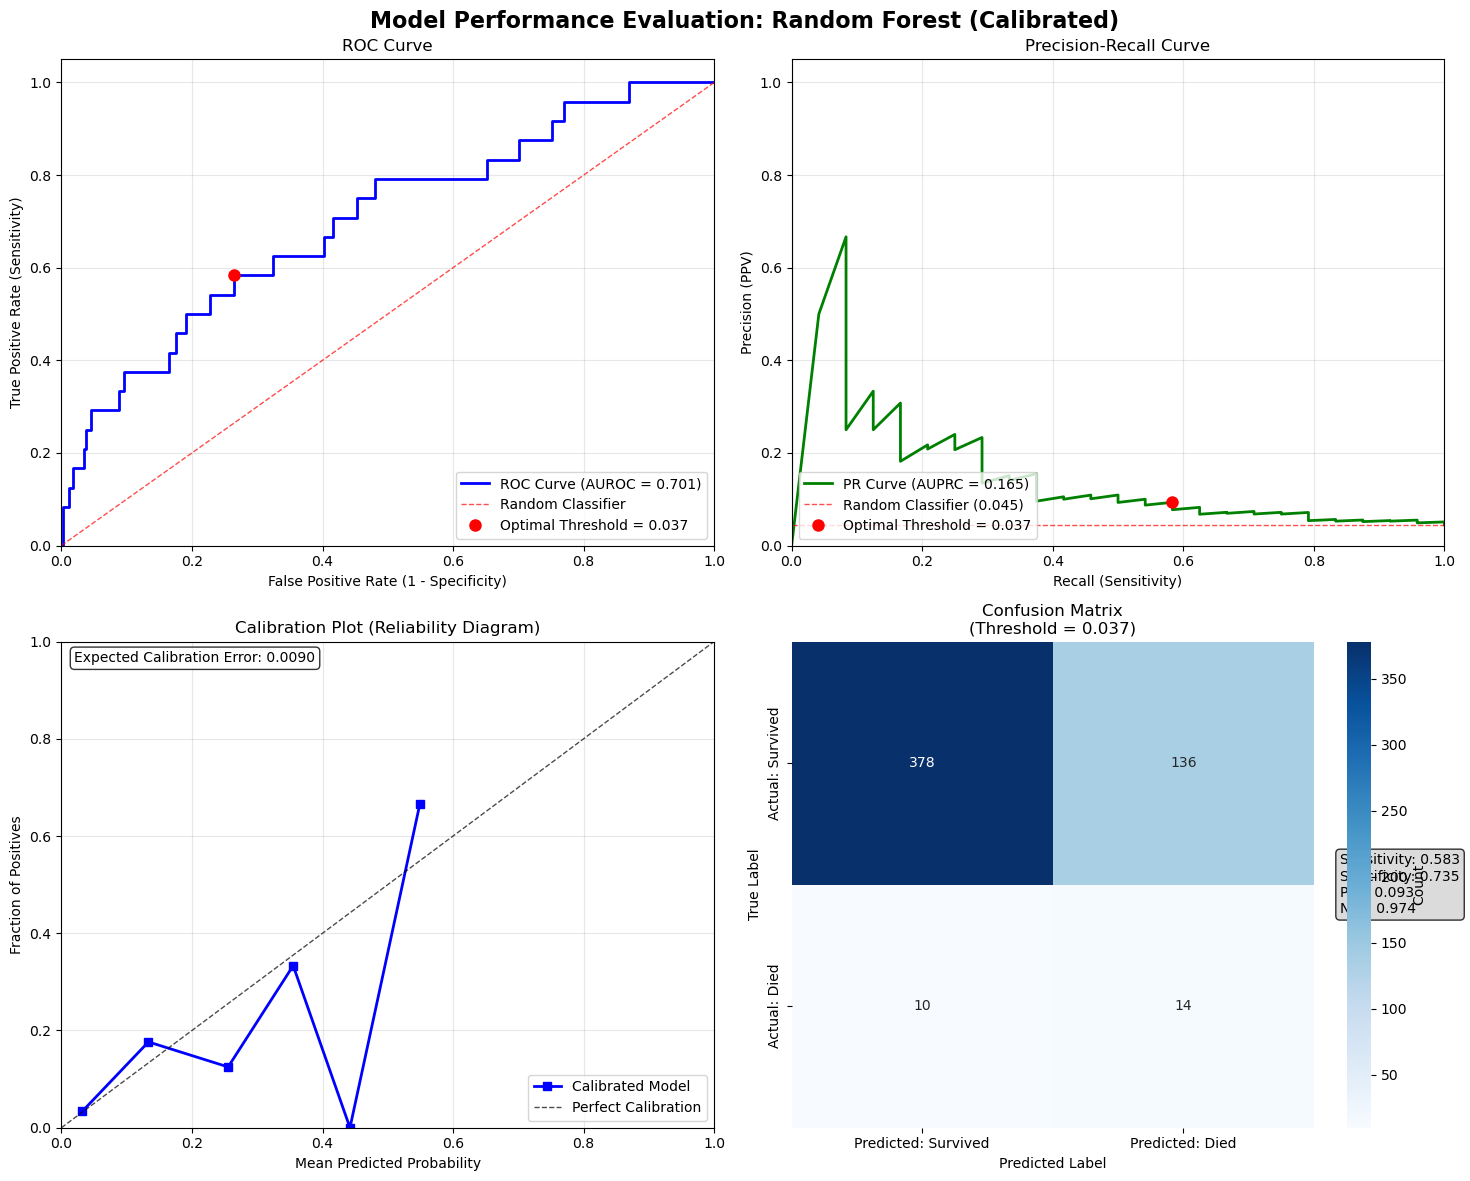

📊 All visualization plots generated!

🎉 MODELING AND EVALUATION COMPLETE!

📋 FINAL RESULTS SUMMARY:
  • Best Model: Random Forest
  • AUROC: 0.7010
  • AUPRC: 0.1651
  • Brier Score: 0.0409
  • Optimal Threshold: 0.0374
  • Test Accuracy: 0.7286
  • Sensitivity: 0.5833
  • Specificity: 0.7354


In [27]:
# ====================================================================
# CALIBRATION PLOT & CONFUSION MATRIX
# ====================================================================

# ====================================================================
# CALIBRATION PLOT
# ====================================================================
ax3 = axes[1, 0]

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, test_probs, n_bins=10, strategy='uniform'
)

# Plot calibration curve
ax3.plot(mean_predicted_value, fraction_of_positives, "s-", color='blue', lw=2,
         label='Calibrated Model')
ax3.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.7, label='Perfect Calibration')

ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])
ax3.set_xlabel('Mean Predicted Probability')
ax3.set_ylabel('Fraction of Positives')
ax3.set_title('Calibration Plot (Reliability Diagram)')
ax3.legend(loc="lower right")
ax3.grid(True, alpha=0.3)

# Add calibration metrics as text
ece_test = compute_calibration_metrics(y_test, test_probs)
ax3.text(0.02, 0.98, f'Expected Calibration Error: {ece_test:.4f}', 
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ====================================================================
# CONFUSION MATRIX HEATMAP
# ====================================================================
ax4 = axes[1, 1]

# Create heatmap of confusion matrix with optimal threshold
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: Survived', 'Predicted: Died'],
            yticklabels=['Actual: Survived', 'Actual: Died'],
            ax=ax4, cbar_kws={'label': 'Count'})

ax4.set_title(f'Confusion Matrix\n(Threshold = {optimal_threshold:.3f})')
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')

# Add performance metrics as text
metrics_text = f"""Sensitivity: {sensitivity:.3f}
Specificity: {specificity:.3f}
PPV: {ppv:.3f}
NPV: {npv:.3f}"""

ax4.text(1.05, 0.5, metrics_text, transform=ax4.transAxes, 
         verticalalignment='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print("📊 All visualization plots generated!")
print("\n" + "="*60)
print("🎉 MODELING AND EVALUATION COMPLETE!")
print("="*60)
print(f"\n📋 FINAL RESULTS SUMMARY:")
print(f"  • Best Model: {best_model_name}")
print(f"  • AUROC: {test_auroc:.4f}")
print(f"  • AUPRC: {test_auprc:.4f}")
print(f"  • Brier Score: {test_brier:.4f}")
print(f"  • Optimal Threshold: {optimal_threshold:.4f}")
print(f"  • Test Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"  • Sensitivity: {sensitivity:.4f}")
print(f"  • Specificity: {specificity:.4f}")
